# Exploring Yelp Reviews in Philadelphia

In this assignment, we'll explore restaurant review data available through the [Yelp Dataset Challenge](https://www.yelp.com/dataset). The dataset includes Yelp data for user reviews and business information for many metropolitan areas. I've already downloaded this dataset (8 GB total!) and extracted out the data files for reviews and restaurants in Philadelphia. I've placed these data files into the `data` directory in this repository. 

This assignment is broken into two parts:

**Part 1:** Analyzing correlations between restaurant reviews and census data

We'll explore the relationship between restaurant reviews and the income levels of the restaurant's surrounding area.

**Part 2:** Exploring the impact of fast food restaurants

We'll run a sentiment analysis on reviews of fast food restaurants and estimate income levels in neighborhoods with fast food restaurants. We'll test how well our sentiment analysis works by comparing the number of stars to the sentiment of reviews.


**Fun readings**
- [Does sentiment analysis work?](http://varianceexplained.org/r/yelp-sentiment/)
- [The Geography of Taste: Using Yelp to Study Urban Culture](https://www.mdpi.com/2220-9964/7/9/376/pdf/1)

## 1. Correlating restaurant ratings and income levels

In this part, we'll use the census API to download household income data and explore how it correlates with restaurant review data.

### 1.1 Query the Census API

Use the `cenpy` package to download **median household income in the past 12 months** by census tract from the 2021 ACS 5-year data set for your county of interest.

You have two options to find the correct variable names:
- Search through: [https://api.census.gov/data/2021/acs/acs5/variables.html](https://api.census.gov/data/2021/acs/acs5/variables.html)
- Initialize an API connection and use the `.varslike()` function to search for the proper keywords 

At the end of this step, you should have a pandas DataFrame holding the income data for all census tracts within the county being analyzed. Feel free to rename your variable from the ACS so it has a more meaningful name!

::: {.callout-caution}
Some census tracts won't have any value because there are not enough households in that tract. The census will use a negative number as a default value for those tracts. You can safely remove those tracts from the analysis!
:::

In [3]:
import cenpy 
import pandas as pd
import numpy as np
import pygris
import json
import gzip
import geopandas as gpd
from shapely.geometry import Point

In [4]:
available = cenpy.explorer.available()
available.filter(regex="^ACSDT5Y", axis=0)

,c_isTimeseries,temporal,spatial,c_isAggregate,publisher,references,programCode,modified,license,keyword,...,description,bureauCode,accessLevel,title,c_isAvailable,c_isCube,c_isMicrodata,c_documentationLink,c_dataset,vintage
ACSDT5Y2009,NaN,NaN,NaN,True,U.S. Census Bureau,https://www.census.gov/developers/,006:004,2019-08-27 13:11:18.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",...,The American Community Survey (ACS) is an ongo...,006:07,public,American Community Survey: 5-Year Estimates: D...,True,True,NaN,https://www.census.gov/developer/,"(acs, acs5)",2009.0
ACSDT5Y2010,NaN,NaN,United States,True,U.S. Census Bureau,https://www.census.gov/developers/,006:004,2018-07-04 00:00:00.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",...,The American Community Survey (ACS) is an ongo...,006:07,public,ACS 5-Year Detailed Tables,True,True,NaN,https://www.census.gov/developer/,"(acs, acs5)",2010.0
ACSDT5Y2011,NaN,NaN,NaN,True,U.S. Census Bureau,https://www.census.gov/developers/,006:004,2018-07-04 00:00:00.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",...,The American Community Survey (ACS) is an ongo...,006:07,public,ACS 5-Year Detailed Tables,True,True,NaN,https://www.census.gov/developer/,"(acs, acs5)",2011.0
ACSDT5Y2012,NaN,NaN,NaN,True,U.S. Census Bureau,https://www.census.gov/developers/,006:004,2018-07-04 00:00:00.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",...,The American Community Survey (ACS) is an ongo...,006:07,public,ACS 5-Year Detailed Tables,True,True,NaN,https://www.census.gov/developer/,"(acs, acs5)",2012.0
ACSDT5Y2013,NaN,NaN,NaN,True,U.S. Census Bureau,https://www.census.gov/developers/,006:004,2018-07-04 00:00:00.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",...,The American Community Survey (ACS) is an ongo...,006:07,public,ACS 5-Year Detailed Tables,True,True,NaN,https://www.census.gov/developer/,"(acs, acs5)",2013.0
ACSDT5Y2014,NaN,NaN,NaN,True,U.S. Census Bureau,https://www.census.gov/developers/,006:004,2018-07-04 00:00:00.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",...,The American Community Survey (ACS) is an ongo...,006:07,public,ACS 5-Year Detailed Tables,True,True,NaN,https://www.census.gov/developer/,"(acs, acs5)",2014.0
ACSDT5Y2015,NaN,NaN,NaN,True,U.S. Census Bureau,https://www.census.gov/developers/,006:004,2018-07-05 00:00:00.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",...,The American Community Survey (ACS) is an ongo...,006:07,public,ACS 5-Year Detailed Tables,True,True,NaN,https://www.census.gov/developer/,"(acs, acs5)",2015.0
ACSDT5Y2016,NaN,NaN,NaN,True,U.S. Census Bureau,https://www.census.gov/developers/,006:004,2018-07-05 00:00:00.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",...,The American Community Survey (ACS) is an ongo...,006:07,public,ACS 5-Year Detailed Tables,True,True,NaN,https://www.census.gov/developer/,"(acs, acs5)",2016.0
ACSDT5Y2017,NaN,NaN,NaN,True,U.S. Census Bureau,https://www.census.gov/developers/,006:004,2018-08-21 07:11:43.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",...,The American Community Survey (ACS) is an ongo...,006:07,public,ACS 5-Year Detailed Tables,True,True,NaN,https://www.census.gov/developer/,"(acs, acs5)",2017.0
ACSDT5Y2018,NaN,NaN,NaN,True,U.S. Census Bureau,https://www.census.gov/developers/,006:004,2019-10-22 16:28:02.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",...,The American Community Survey (ACS) is an ongo...,006:07,public,American Community Survey: 5-Year Estimates: D...,True,True,NaN,https://www.census.gov/developer/,"(acs, acs5)",2018.0


In [5]:
available.head()

,c_isTimeseries,temporal,spatial,c_isAggregate,publisher,references,programCode,modified,license,keyword,...,description,bureauCode,accessLevel,title,c_isAvailable,c_isCube,c_isMicrodata,c_documentationLink,c_dataset,vintage
ABSCB2017,NaN,2017/2017,United States,True,U.S. Census Bureau,https://www.census.gov/developers/,006:007,2020-04-30 00:00:00.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",...,The Annual Business Survey (ABS) provides info...,006:07,public,Annual Business Survey: Characteristics of Bus...,True,NaN,NaN,https://www.census.gov/developer/,"(abscb,)",2017.0
ABSCB2018,NaN,2018/2018,United States,True,U.S. Census Bureau,https://www.census.gov/developers/,006:007,2020-10-26 00:00:00.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",...,The Annual Business Survey (ABS) provides info...,006:07,public,Annual Business Survey: Characteristics of Bus...,True,NaN,NaN,https://www.census.gov/developer/,"(abscb,)",2018.0
ABSCB2019,NaN,2019/2019,US,True,U.S. Census Bureau,https://www.census.gov/developers/,006:007,2021-08-17 00:00:00.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",...,The Annual Business Survey (ABS) provides info...,006:07,public,2019 Annual Business Survey: Characteristics o...,True,NaN,NaN,https://www.census.gov/developer/,"(abscb,)",2019.0
ABSCB2020,NaN,2020/2020,US,True,U.S. Census Bureau,https://www.census.gov/developers/,006:007,2022-08-03 00:00:00.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",...,The Annual Business Survey (ABS) provides info...,006:07,public,2020 Annual Business Survey: Characteristics o...,True,NaN,NaN,https://www.census.gov/developer/,"(abscb,)",2020.0
ABSCB2021,NaN,2021/2021,United States,True,U.S. Census Bureau,https://www.census.gov/developers/,006:007,2023-07-24 10:30:52.0,https://creativecommons.org/publicdomain/zero/...,"(census,)",...,The Annual Business Survey (ABS) provides info...,006:07,public,2021 Annual Business Survey: Characteristics o...,True,NaN,NaN,https://www.census.gov/developer/,"(abscb,)",2021.0


In [6]:
cenpy.explorer.explain("ACSDT5Y2021")

{'American Community Survey: 5-Year Estimates: Detailed Tables 5-Year': 'The American Community Survey (ACS) is an ongoing survey that provides data every year -- giving communities the current information they need to plan investments and services. The ACS covers a broad range of topics about social, economic, demographic, and housing characteristics of the U.S. population. Summary files include the following geographies: nation, all states (including DC and Puerto Rico), all metropolitan areas, all congressional districts, all counties, all places, and all tracts and block groups. Summary files contain the most detailed cross-tabulations, many of which are published down to block groups. The data are population and housing counts. There are over 64,000 variables in this dataset.'}

In [7]:
acs = cenpy.remote.APIConnection("ACSDT5Y2021")

In [8]:
income_matches = acs.varslike(
    pattern="MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS",
    by="concept",  # searches along concept column
).sort_index()

In [ ]:
income_matches = acs.varslike(
    
)

In [9]:
income_matches.head()

,label,concept,predicateType,group,limit,predicateOnly,hasGeoCollectionSupport,attributes,required
B19013A_001E,Estimate!!Median household income in the past ...,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,int,B19013A,0,NaN,NaN,"B19013A_001EA,B19013A_001M,B19013A_001MA",NaN
B19013B_001E,Estimate!!Median household income in the past ...,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,int,B19013B,0,NaN,NaN,"B19013B_001EA,B19013B_001M,B19013B_001MA",NaN
B19013C_001E,Estimate!!Median household income in the past ...,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,int,B19013C,0,NaN,NaN,"B19013C_001EA,B19013C_001M,B19013C_001MA",NaN
B19013D_001E,Estimate!!Median household income in the past ...,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,int,B19013D,0,NaN,NaN,"B19013D_001EA,B19013D_001M,B19013D_001MA",NaN
B19013E_001E,Estimate!!Median household income in the past ...,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,int,B19013E,0,NaN,NaN,"B19013E_001EA,B19013E_001M,B19013E_001MA",NaN


In [10]:
variables = ["B19019_001E"]
philly_county_code = "101"
pa_state_code = "42"

In [11]:
data = acs.query(
    cols=variables,
    geo_unit="tract:*",
    geo_filter = {
        "state": pa_state_code,
        "county": philly_county_code
    } 
)

data.head()

,B19019_001E,state,county,tract
0,104052,42,101,000101
1,91944,42,101,000102
2,91067,42,101,000200
3,86782,42,101,000300
4,67188,42,101,000401


In [12]:
income = data.rename(columns={'B19019_001E': 'median income'}, inplace=False)

income

,median income,state,county,tract
0,104052,42,101,000101
1,91944,42,101,000102
2,91067,42,101,000200
3,86782,42,101,000300
4,67188,42,101,000401
...,...,...,...,...
403,-666666666,42,101,980905
404,-666666666,42,101,980906
405,-666666666,42,101,989100
406,-666666666,42,101,989200


In [13]:
#Removing tracts with negative values

income['median income'] = pd.to_numeric(income['median income'], errors='coerce')

income = income[income['median income'] >= 0]

income = income.dropna(subset=['median income'])

In [14]:
income

,median income,state,county,tract
0,104052,42,101,000101
1,91944,42,101,000102
2,91067,42,101,000200
3,86782,42,101,000300
4,67188,42,101,000401
...,...,...,...,...
383,46250,42,101,038900
384,33711,42,101,039001
385,55965,42,101,039002
386,30077,42,101,039100


### 1.2 Download census tracts from the Census and merge the data from part 1.1

- Download census tracts for the desired geography using the `pygris` package
- Merge the downloaded census tracts with the household income DataFrame

In [15]:
tracts = pygris.tracts(
    state=pa_state_code, county=philly_county_code, year=2021
)

tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
68,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,+39.9332720,-075.2132103,"POLYGON ((-75.22235 39.93105, -75.22129 39.931..."
69,42,101,980902,42101980902,9809.02,Census Tract 9809.02,G5020,S,132548,50536,+39.9346276,-075.2046321,"POLYGON ((-75.20684 39.93409, -75.20655 39.934..."
70,42,101,980904,42101980904,9809.04,Census Tract 9809.04,G5020,S,1570844,158459,+39.9247300,-075.2036710,"POLYGON ((-75.21243 39.92523, -75.21130 39.928..."
71,42,101,980903,42101980903,9809.03,Census Tract 9809.03,G5020,S,171154,0,+39.9347932,-075.2009884,"POLYGON ((-75.20422 39.93285, -75.20305 39.934..."
72,42,101,980906,42101980906,9809.06,Census Tract 9809.06,G5020,S,2945390,383112,+39.9095823,-075.1984052,"POLYGON ((-75.21612 39.90964, -75.21454 39.910..."


In [16]:
philly_final = tracts.merge(
    income,
    left_on=["STATEFP", "COUNTYFP", "TRACTCE"],
    right_on=["state", "county", "tract"],
)

philly_final

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,median income,state,county,tract
0,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,+39.9332720,-075.2132103,"POLYGON ((-75.22235 39.93105, -75.22129 39.931...",30077,42,101,039100
1,42,101,036700,42101036700,367,Census Tract 367,G5020,S,729908,0,+39.9611378,-075.1438094,"POLYGON ((-75.14886 39.95774, -75.14885 39.957...",150952,42,101,036700
2,42,101,034702,42101034702,347.02,Census Tract 347.02,G5020,S,1032346,0,+40.0569545,-075.0282679,"POLYGON ((-75.03647 40.05396, -75.03637 40.054...",93397,42,101,034702
3,42,101,034801,42101034801,348.01,Census Tract 348.01,G5020,S,1385962,5188,+40.0532771,-075.0158917,"POLYGON ((-75.02482 40.06029, -75.02466 40.060...",65357,42,101,034801
4,42,101,034802,42101034802,348.02,Census Tract 348.02,G5020,S,1232182,8015,+40.0687145,-075.0097300,"POLYGON ((-75.02184 40.06326, -75.02171 40.063...",52519,42,101,034802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,42,101,013602,42101013602,136.02,Census Tract 136.02,G5020,S,246812,0,+39.9716057,-075.1800748,"POLYGON ((-75.18637 39.97354, -75.18604 39.973...",103426,42,101,013602
378,42,101,034502,42101034502,345.02,Census Tract 345.02,G5020,S,1021734,0,+40.0814101,-075.0384569,"POLYGON ((-75.04729 40.08293, -75.04652 40.083...",49636,42,101,034502
379,42,101,000902,42101000902,9.02,Census Tract 9.02,G5020,S,155167,0,+39.9471596,-075.1566389,"POLYGON ((-75.16017 39.94686, -75.16014 39.947...",67014,42,101,000902
380,42,101,001201,42101001201,12.01,Census Tract 12.01,G5020,S,327555,30728,+39.9470373,-075.1799169,"POLYGON ((-75.18714 39.94722, -75.18563 39.948...",106871,42,101,001201


### 1.3 Load the restaurants data

The Yelp dataset includes data for 7,350 restaurants across the city. Load the data from the `data/` folder and use the `latitude` and `longitude` columns to create a GeoDataFrame after loading the JSON data. Be sure to set the right CRS on when initializing the GeoDataFrame!

**Notes**

The JSON data is in a "records" format. To load it, you'll need to pass the following keywords: 

- `orient='records'`
- `lines=True`

In [17]:
with gzip.open("data/restaurants_philly.json.gz", "rt", encoding="utf-8") as f:
    records = pd.read_json(f, orient='records', lines=True)

In [18]:
geometry = [Point(lon, lat) for lon, lat in zip(records['longitude'], records['latitude'])]
restaurants = gpd.GeoDataFrame(records, geometry=geometry)
restaurants.set_crs(epsg=4326, inplace=True)

restaurants.head()

,business_id,latitude,longitude,name,review_count,stars,categories,geometry
0,MTSW4McQd7CbVtyjqoe9mw,39.955505,-75.155564,St Honore Pastries,80,4.0,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",POINT (-75.15556 39.95551)
1,MUTTqe8uqyMdBl186RmNeA,39.953949,-75.143226,Tuna Bar,245,4.0,"Sushi Bars, Restaurants, Japanese",POINT (-75.14323 39.95395)
2,ROeacJQwBeh05Rqg7F6TCg,39.943223,-75.162568,BAP,205,4.5,"Korean, Restaurants",POINT (-75.16257 39.94322)
3,QdN72BWoyFypdGJhhI5r7g,39.939825,-75.157447,Bar One,65,4.0,"Cocktail Bars, Bars, Italian, Nightlife, Resta...",POINT (-75.15745 39.93982)
4,Mjboz24M9NlBeiOJKLEd_Q,40.022466,-75.218314,DeSandro on Main,41,3.0,"Pizza, Restaurants, Salad, Soup",POINT (-75.21831 40.02247)


### 1.4 Add tract info for each restaurant

Do a spatial join to identify which census tract each restaurant is within. Make sure each dataframe has the same CRS!

At the end of this step, you should have a new dataframe with a column identifying the tract number for each restaurant.

In [19]:
tracts = gpd.GeoDataFrame(tracts, geometry='geometry')

In [20]:
restaurants = restaurants.to_crs('EPSG:4326')
tracts = tracts.to_crs('EPSG:4326')

In [21]:
tracts_cut = tracts.drop(columns=['STATEFP', 'COUNTYFP', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON'])

tracts_cut

,TRACTCE,GEOID,NAME,NAMELSAD,geometry
68,039100,42101039100,391,Census Tract 391,"POLYGON ((-75.22235 39.93105, -75.22129 39.931..."
69,980902,42101980902,9809.02,Census Tract 9809.02,"POLYGON ((-75.20684 39.93409, -75.20655 39.934..."
70,980904,42101980904,9809.04,Census Tract 9809.04,"POLYGON ((-75.21243 39.92523, -75.21130 39.928..."
71,980903,42101980903,9809.03,Census Tract 9809.03,"POLYGON ((-75.20422 39.93285, -75.20305 39.934..."
72,980906,42101980906,9809.06,Census Tract 9809.06,"POLYGON ((-75.21612 39.90964, -75.21454 39.910..."
...,...,...,...,...,...
3399,013602,42101013602,136.02,Census Tract 136.02,"POLYGON ((-75.18637 39.97354, -75.18604 39.973..."
3400,034502,42101034502,345.02,Census Tract 345.02,"POLYGON ((-75.04728 40.08293, -75.04652 40.083..."
3401,000902,42101000902,9.02,Census Tract 9.02,"POLYGON ((-75.16017 39.94686, -75.16014 39.947..."
3402,001201,42101001201,12.01,Census Tract 12.01,"POLYGON ((-75.18714 39.94722, -75.18563 39.948..."


In [22]:
restaurants_tracts = restaurants.sjoin(tracts_cut, how='left',predicate='within')

restaurants_tracts

,business_id,latitude,longitude,name,review_count,stars,categories,geometry,index_right,TRACTCE,GEOID,NAME,NAMELSAD
0,MTSW4McQd7CbVtyjqoe9mw,39.955505,-75.155564,St Honore Pastries,80,4.0,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",POINT (-75.15556 39.95551),1598.0,000200,42101000200,2,Census Tract 2
1,MUTTqe8uqyMdBl186RmNeA,39.953949,-75.143226,Tuna Bar,245,4.0,"Sushi Bars, Restaurants, Japanese",POINT (-75.14323 39.95395),3134.0,000102,42101000102,1.02,Census Tract 1.02
2,ROeacJQwBeh05Rqg7F6TCg,39.943223,-75.162568,BAP,205,4.5,"Korean, Restaurants",POINT (-75.16257 39.94322),236.0,001500,42101001500,15,Census Tract 15
3,QdN72BWoyFypdGJhhI5r7g,39.939825,-75.157447,Bar One,65,4.0,"Cocktail Bars, Bars, Italian, Nightlife, Resta...",POINT (-75.15745 39.93982),188.0,001800,42101001800,18,Census Tract 18
4,Mjboz24M9NlBeiOJKLEd_Q,40.022466,-75.218314,DeSandro on Main,41,3.0,"Pizza, Restaurants, Salad, Soup",POINT (-75.21831 40.02247),3096.0,021000,42101021000,210,Census Tract 210
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7345,VZbkSeZtFynEascotq7ExA,39.953391,-75.196765,Ali Baba Magic Food,8,4.0,"Restaurants, Food Stands",POINT (-75.19677 39.95339),2734.0,008801,42101008801,88.01,Census Tract 88.01
7346,gPr1io7ks0Eo3FDsnDTYfg,40.060414,-75.191084,Tata Cafe,21,4.0,"Sandwiches, Restaurants, Italian",POINT (-75.19108 40.06041),2720.0,025600,42101025600,256,Census Tract 256
7347,wVxXRFf10zTTAs11nr4xeA,40.032483,-75.214430,PrimoHoagies,55,3.0,"Restaurants, Specialty Food, Food, Sandwiches,...",POINT (-75.21443 40.03248),2143.0,021300,42101021300,213,Census Tract 213
7348,8n93L-ilMAsvwUatarykSg,39.951018,-75.198240,Kitchen Gia,22,3.0,"Coffee & Tea, Food, Sandwiches, American (Trad...",POINT (-75.19824 39.95102),3138.0,036902,42101036902,369.02,Census Tract 369.02


### 1.5 Add income data to your restaurant data

Add the income data to your dataframe from the previous step, merging the census data based on the tract that each restaurant is within.

In [23]:
restaurants_income = pd.merge(restaurants_tracts, philly_final, on='NAMELSAD', how='left')

restaurants_income

,business_id,latitude,longitude,name,review_count,stars,categories,geometry_x,index_right,TRACTCE_x,...,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry_y,median income,state,county,tract
0,MTSW4McQd7CbVtyjqoe9mw,39.955505,-75.155564,St Honore Pastries,80,4.0,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",POINT (-75.15556 39.95551),1598.0,000200,...,S,386232.0,0.0,+39.9554162,-075.1569255,"POLYGON ((-75.16289 39.95533, -75.16269 39.956...",91067.0,42,101,000200
1,MUTTqe8uqyMdBl186RmNeA,39.953949,-75.143226,Tuna Bar,245,4.0,"Sushi Bars, Restaurants, Japanese",POINT (-75.14323 39.95395),3134.0,000102,...,S,444406.0,0.0,+39.9547160,-075.1465255,"POLYGON ((-75.15155 39.95544, -75.15148 39.955...",91944.0,42,101,000102
2,ROeacJQwBeh05Rqg7F6TCg,39.943223,-75.162568,BAP,205,4.5,"Korean, Restaurants",POINT (-75.16257 39.94322),236.0,001500,...,S,239383.0,0.0,+39.9419037,-075.1591158,"POLYGON ((-75.16599 39.94182, -75.16585 39.942...",93203.0,42,101,001500
3,QdN72BWoyFypdGJhhI5r7g,39.939825,-75.157447,Bar One,65,4.0,"Cocktail Bars, Bars, Italian, Nightlife, Resta...",POINT (-75.15745 39.93982),188.0,001800,...,S,242440.0,0.0,+39.9400001,-075.1593102,"POLYGON ((-75.16636 39.94003, -75.16627 39.940...",99125.0,42,101,001800
4,Mjboz24M9NlBeiOJKLEd_Q,40.022466,-75.218314,DeSandro on Main,41,3.0,"Pizza, Restaurants, Salad, Soup",POINT (-75.21831 40.02247),3096.0,021000,...,S,858218.0,55718.0,+40.0244730,-075.2151045,"POLYGON ((-75.22346 40.02415, -75.22306 40.024...",79264.0,42,101,021000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7345,VZbkSeZtFynEascotq7ExA,39.953391,-75.196765,Ali Baba Magic Food,8,4.0,"Restaurants, Food Stands",POINT (-75.19677 39.95339),2734.0,008801,...,S,184674.0,0.0,+39.9539319,-075.1984477,"POLYGON ((-75.20066 39.95209, -75.20052 39.952...",36250.0,42,101,008801
7346,gPr1io7ks0Eo3FDsnDTYfg,40.060414,-75.191084,Tata Cafe,21,4.0,"Sandwiches, Restaurants, Italian",POINT (-75.19108 40.06041),2720.0,025600,...,S,865284.0,1982.0,+40.0683411,-075.1883025,"POLYGON ((-75.19639 40.06662, -75.19626 40.066...",92404.0,42,101,025600
7347,wVxXRFf10zTTAs11nr4xeA,40.032483,-75.214430,PrimoHoagies,55,3.0,"Restaurants, Specialty Food, Food, Sandwiches,...",POINT (-75.21443 40.03248),2143.0,021300,...,S,538872.0,0.0,+40.0322339,-075.2181174,"POLYGON ((-75.22585 40.03351, -75.22432 40.034...",79464.0,42,101,021300
7348,8n93L-ilMAsvwUatarykSg,39.951018,-75.198240,Kitchen Gia,22,3.0,"Coffee & Tea, Food, Sandwiches, American (Trad...",POINT (-75.19824 39.95102),3138.0,036902,...,S,883507.0,49251.0,+39.9523358,-075.1889603,"POLYGON ((-75.19943 39.95042, -75.19920 39.951...",27821.0,42,101,036902


### 1.6 Make a plot of median household income vs. Yelp stars

Our dataset has the number of stars for each restaurant, rounded to the nearest 0.5 star. In this step, create a line plot that shows the average income value for each stars category (e.g., all restaurants with 1 star, 1.5 stars, 2 stars, etc.)

While their are multiple ways to do this, the [seaborn.lineplot()](https://seaborn.pydata.org/generated/seaborn.lineplot.html) is a great option. This can show the average value in each category as well as 95% uncertainty intervals. Use this function to plot the stars ("x") vs. average income ("y") for all of our restaurants, using the dataframe from last step. Be sure to format your figure to make it look nice!

**Question:** Is there a correlation between a restaurant's ratings and the income levels of its surrounding neighborhood?

In [24]:
import seaborn

<Axes: xlabel='stars', ylabel='median income'>

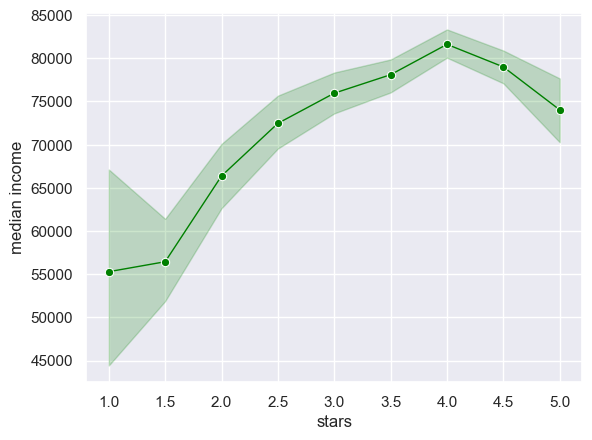

In [25]:
seaborn.set_theme(style="darkgrid")
seaborn.lineplot(data=restaurants_income, 
                 x='stars', 
                 y='median income', 
                 color='green', 
                 marker='o', 
                 linewidth=1,)

There appears to be a correlation between ratings and median income. Restaurants with higher ratings appear to be in census tracts with higher median incomes. 

## 2. Fast food trends in Philadelphia

At the end of part 1, you should have seen a strong trend where higher income tracts generally had restaurants with better reviews. In this section, we'll explore the impact of fast food restaurants and how they might be impacting this trend. 

**Hypothesis**

1. Fast food restaurants are predominantly located in areas with lower median income levels. 
1. Fast food restaurants have worse reviews compared to typical restaurants. 

If true, these two hypotheses could help to explain the trend we found in part 1. Let's dive in and test our hypotheses!

### 2.1 Identify fast food restaurants

The "categories" column in our dataset contains multiple classifications for each restaurant. One such category is "Fast Food". In this step, add a new column called "is_fast_food" that is `True` if the "categories" column contains the term "Fast Food" and `False` otherwise

In [26]:
restaurants_income['is_fast_food'] = restaurants_income['categories'].str.contains('fast food', case=False, na=False)

#Checking to make sure the column was created 
num_fast_food = restaurants_income['is_fast_food'].sum()
print(num_fast_food)


367


In [27]:
restaurants_income.head()

,business_id,latitude,longitude,name,review_count,stars,categories,geometry_x,index_right,TRACTCE_x,...,ALAND,AWATER,INTPTLAT,INTPTLON,geometry_y,median income,state,county,tract,is_fast_food
0,MTSW4McQd7CbVtyjqoe9mw,39.955505,-75.155564,St Honore Pastries,80,4.0,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",POINT (-75.15556 39.95551),1598.0,000200,...,386232.0,0.0,+39.9554162,-075.1569255,"POLYGON ((-75.16289 39.95533, -75.16269 39.956...",91067.0,42,101,000200,False
1,MUTTqe8uqyMdBl186RmNeA,39.953949,-75.143226,Tuna Bar,245,4.0,"Sushi Bars, Restaurants, Japanese",POINT (-75.14323 39.95395),3134.0,000102,...,444406.0,0.0,+39.9547160,-075.1465255,"POLYGON ((-75.15155 39.95544, -75.15148 39.955...",91944.0,42,101,000102,False
2,ROeacJQwBeh05Rqg7F6TCg,39.943223,-75.162568,BAP,205,4.5,"Korean, Restaurants",POINT (-75.16257 39.94322),236.0,001500,...,239383.0,0.0,+39.9419037,-075.1591158,"POLYGON ((-75.16599 39.94182, -75.16585 39.942...",93203.0,42,101,001500,False
3,QdN72BWoyFypdGJhhI5r7g,39.939825,-75.157447,Bar One,65,4.0,"Cocktail Bars, Bars, Italian, Nightlife, Resta...",POINT (-75.15745 39.93982),188.0,001800,...,242440.0,0.0,+39.9400001,-075.1593102,"POLYGON ((-75.16636 39.94003, -75.16627 39.940...",99125.0,42,101,001800,False
4,Mjboz24M9NlBeiOJKLEd_Q,40.022466,-75.218314,DeSandro on Main,41,3.0,"Pizza, Restaurants, Salad, Soup",POINT (-75.21831 40.02247),3096.0,021000,...,858218.0,55718.0,+40.0244730,-075.2151045,"POLYGON ((-75.22346 40.02415, -75.22306 40.024...",79264.0,42,101,021000,False


### 2.2 Calculate the median income for fast food and otherwise

Group by the "is_fast_food" column and calculate the median income for restaurants that are and are not fast food. You should find that income levels are lower in tracts with fast food.

*Note:* this is just an estimate, since we are calculating a median of median income values.

In [28]:
fast_food_income = restaurants_income.groupby('is_fast_food')['median income'].mean().reset_index()

fast_food_income

,is_fast_food,median income
0,False,77775.179312
1,True,64396.048338


### 2.3 Load fast food review data

In the rest of part 2, we're going to run a sentiment analysis on the reviews for fast food restaurants. 
The review data for all fast food restaurants identified in part 2.1 is already stored in the `data/` folder. The data is stored as a JSON file and you can use `pandas.read_json` to load it. 

**Notes**

The JSON data is in a "records" format. To load it, you'll need to pass the following keywords: 

- `orient='records'`
- `lines=True`

In [29]:
reviews_file_path = 'data\\reviews_philly_fast_food.json.gz'

reviews = pd.read_json(reviews_file_path, orient='records', lines=True)

print(reviews.head())

              business_id               review_id  stars  \
0  kgMEBZG6rjkGeFzPaIM4MQ  E-yGr1OhsUBxNeUVLDVouA      1   
1  FKrP06TDAKtxNG1vrRQcQQ  0IpFZoaY_RRNjha8Q_Wz6w      2   
2  w9hS5x1F52Id-G1KTrAOZg  0KlwfaHZyvao41_3S47dyg      2   
3  fr2qDm_mY1afIGMvqsKUCg  oKSUOq7pCQzyypFDSa1HoA      3   
4  fr2qDm_mY1afIGMvqsKUCg  6SMUmb7Npwnq6AusxqOXzQ      5   

                                                text  
0  I know I shouldn't expect much but everything ...  
1  Perfect place to go  if you like waiting 20 mi...  
2  Was not a fan of their cheesesteak. Their wiz ...  
3  Ok this is an aberration from my city foodie r...  
4  My family has been customers of George's for y...  


### 2.4 Trim to the most popular fast food restaurants

There's too many reviews to run a sentiment analysis on all of them in a reasonable time. Let's trim our reviews dataset to the most popular fast food restaurants, using the list provided below.

You will need to get the "business_id" values for each of these restaurants from the restaurants data loaded in part 1.3. Then, trim the reviews data to include reviews only for those business IDs.

In [30]:
popular_fast_food = [
    "McDonald's",
    "Wendy's",
    "Subway",
    "Popeyes Louisiana Kitchen",
    "Taco Bell",
    "KFC",
    "Burger King",
]

In [31]:
popular_restaurants = restaurants_income[restaurants_income['name'].isin(popular_fast_food)]

popular_restaurants = popular_restaurants.drop(columns=['latitude', 'longitude', 'stars', 'ALAND', 'AWATER', 'state', 'county', 'geometry_x', 'geometry_y'])

popular_restaurants.head()

,business_id,name,review_count,categories,index_right,TRACTCE_x,GEOID_x,NAME_x,NAMELSAD,STATEFP,...,TRACTCE_y,GEOID_y,NAME_y,MTFCC,FUNCSTAT,INTPTLAT,INTPTLON,median income,tract,is_fast_food
11,O1oZpbZNDMH_gz8DhsZCdA,Wendy's,15,"Burgers, Restaurants, Fast Food",3155.0,989300,42101989300,9893,Census Tract 9893,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
37,yFqq66GxRjnhZXPgjA6hnw,KFC,7,"Restaurants, Chicken Shop, Fast Food, Chicken ...",2141.0,029100,42101029100,291,Census Tract 291,42,...,029100,42101029100,291,G5020,S,+40.0374996,-075.1067520,24000.0,029100,True
39,kLSEk3qXY1KdtFjxHJ9pww,McDonald's,20,"Restaurants, Fast Food, Food, Coffee & Tea, Bu...",1860.0,036301,42101036301,363.01,Census Tract 363.01,42,...,036301,42101036301,363.01,G5020,S,+40.0895349,-074.9667387,77115.0,036301,True
81,kgMEBZG6rjkGeFzPaIM4MQ,McDonald's,55,"Fast Food, Food, Restaurants, Coffee & Tea, Bu...",189.0,001900,42101001900,19,Census Tract 19,42,...,001900,42101001900,19,G5020,S,+39.9400454,-075.1722270,138093.0,001900,True
193,gq4zw-ru_rkZ2UBIanaZFQ,McDonald's,38,"Fast Food, Food, Burgers, Coffee & Tea, Restau...",1968.0,014100,42101014100,141,Census Tract 141,42,...,014100,42101014100,141,G5020,S,+39.9708770,-075.1524555,18736.0,014100,True


In [32]:
popular_ids = popular_restaurants['business_id'].unique()

In [33]:
reviews = reviews[reviews['business_id'].isin(popular_ids)]

reviews_with_restaurant_info = reviews.merge(
    popular_restaurants, 
    on='business_id', 
    how='left'
)

reviews_with_restaurant_info.head()

,business_id,review_id,stars,text,name,review_count,categories,index_right,TRACTCE_x,GEOID_x,...,TRACTCE_y,GEOID_y,NAME_y,MTFCC,FUNCSTAT,INTPTLAT,INTPTLON,median income,tract,is_fast_food
0,kgMEBZG6rjkGeFzPaIM4MQ,E-yGr1OhsUBxNeUVLDVouA,1,I know I shouldn't expect much but everything ...,McDonald's,55,"Fast Food, Food, Restaurants, Coffee & Tea, Bu...",189.0,001900,42101001900,...,001900,42101001900,19,G5020,S,+39.9400454,-075.1722270,138093.0,001900,True
1,PjknD8uD_0tisZQbomiYoQ,6TqKBa-HDiq2_W_ip2AItA,5,I am only giving 5 stars because the Shamrock ...,McDonald's,48,"Restaurants, Burgers, Food, Coffee & Tea, Fast...",3153.0,000805,42101000805,...,000805,42101000805,8.05,G5020,S,+39.9487605,-075.1693486,80772.0,000805,True
2,kgMEBZG6rjkGeFzPaIM4MQ,NGaXI03qbtBLshjfJV4pbQ,3,"Dirty bathrooms and very slow service, but I w...",McDonald's,55,"Fast Food, Food, Restaurants, Coffee & Tea, Bu...",189.0,001900,42101001900,...,001900,42101001900,19,G5020,S,+39.9400454,-075.1722270,138093.0,001900,True
3,LACylKxImNI29DKUQpWuHw,HHy9yIjW07VHUE6nXVbsVA,3,Burger King is an okay alternative to Mcdonald...,Burger King,32,"Restaurants, Burgers, Fast Food",235.0,000600,42101000600,...,000600,42101000600,6,G5020,S,+39.9493845,-075.1583355,90119.0,000600,True
4,gq4zw-ru_rkZ2UBIanaZFQ,yMZTK5B_0SAdUXSrIkXrmA,1,ive tried going here four times with no succes...,McDonald's,38,"Fast Food, Food, Burgers, Coffee & Tea, Restau...",1968.0,014100,42101014100,...,014100,42101014100,141,G5020,S,+39.9708770,-075.1524555,18736.0,014100,True


### 2.5 Run the emotions classifier on fast food reviews

Run a sentiment analysis on the reviews data from the previous step. Use the [DistilBERT model](https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion) that can predict emotion labels (anger, fear, sadness, joy, love, and surprise). Transform the result from the classifier into a DataFrame so that you have a column for each of the emotion labels.

In [31]:
pip install transformers torch pandas

Note: you may need to restart the kernel to use updated packages.


In [34]:
from transformers import pipeline

In [35]:
emotion_pipeline = pipeline("text-classification", model="nateraw/bert-base-uncased-emotion")

c:\Users\cnmit\anaconda3\envs\musa-550-fall-2023\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [36]:
model = "bhadresh-savani/distilbert-base-uncased-emotion"

emotion_classifier = pipeline(
    task="text-classification",  
    model=model,  
    top_k=None,  
    tokenizer=model,  
    truncation=True,  
)

c:\Users\cnmit\anaconda3\envs\musa-550-fall-2023\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [37]:
text = reviews_with_restaurant_info.dropna(subset=["text"])
text = reviews_with_restaurant_info.loc[text["text"] != ""]


text = reviews_with_restaurant_info["text"].str.strip().tolist() 

In [36]:
%%time 

emotion_scores = emotion_classifier(text)

CPU times: total: 19min 1s
Wall time: 3min 11s


In [37]:
emotion = pd.DataFrame(
    [{d["label"]: d["score"] for d in dd} for dd in emotion_scores]
).assign(text=text)

emotion.head()

,sadness,fear,anger,joy,surprise,love,text
0,0.733869,0.250677,0.011039,0.002758,0.001015,0.000643,I know I shouldn't expect much but everything ...
1,0.000230,0.000126,0.000165,0.998759,0.000246,0.000475,I am only giving 5 stars because the Shamrock ...
2,0.000216,0.000088,0.000153,0.998563,0.000161,0.000819,"Dirty bathrooms and very slow service, but I w..."
3,0.000838,0.000403,0.000811,0.996928,0.000140,0.000880,Burger King is an okay alternative to Mcdonald...
4,0.005284,0.000753,0.006195,0.985421,0.001620,0.000726,ive tried going here four times with no succes...


### 2.6 Identify the predicted emotion for each text

Use the pandas [idxmax()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmax.html) to identify the predicted emotion for each review, and add this value to a new column called "prediction"

The predicted emotion has the highest confidence score across all emotion labels for a particular label.

In [38]:
emotion_labels = ["anger", "fear", "sadness", "joy", "surprise", "love"]

emotion['prediction'] = emotion[emotion_labels].idxmax(axis=1)

emotion.head()

,sadness,fear,anger,joy,surprise,love,text,prediction
0,0.733869,0.250677,0.011039,0.002758,0.001015,0.000643,I know I shouldn't expect much but everything ...,sadness
1,0.000230,0.000126,0.000165,0.998759,0.000246,0.000475,I am only giving 5 stars because the Shamrock ...,joy
2,0.000216,0.000088,0.000153,0.998563,0.000161,0.000819,"Dirty bathrooms and very slow service, but I w...",joy
3,0.000838,0.000403,0.000811,0.996928,0.000140,0.000880,Burger King is an okay alternative to Mcdonald...,joy
4,0.005284,0.000753,0.006195,0.985421,0.001620,0.000726,ive tried going here four times with no succes...,joy


### 2.7 Combine the ratings and sentiment data

Combine the data from part 2.4 (reviews data) and part 2.6 (emotion data). Use the `pd.concat()` function and combine along the column axis.

**Note:** You'll need to reset the index of your reviews data frame so it matches the emotion data index (it should run from 0 to the length of the data - 1).


In [39]:
reviews_with_restaurant_info = reviews_with_restaurant_info.reset_index(drop=True)

ratings_sentiment = pd.concat([reviews_with_restaurant_info, emotion], axis=1)

In [40]:
ratings_sentiment.head()

,business_id,review_id,stars,text,name,review_count,categories,index_right,TRACTCE_x,GEOID_x,...,tract,is_fast_food,sadness,fear,anger,joy,surprise,love,text,prediction
0,kgMEBZG6rjkGeFzPaIM4MQ,E-yGr1OhsUBxNeUVLDVouA,1,I know I shouldn't expect much but everything ...,McDonald's,55,"Fast Food, Food, Restaurants, Coffee & Tea, Bu...",189.0,001900,42101001900,...,001900,True,0.733869,0.250677,0.011039,0.002758,0.001015,0.000643,I know I shouldn't expect much but everything ...,sadness
1,PjknD8uD_0tisZQbomiYoQ,6TqKBa-HDiq2_W_ip2AItA,5,I am only giving 5 stars because the Shamrock ...,McDonald's,48,"Restaurants, Burgers, Food, Coffee & Tea, Fast...",3153.0,000805,42101000805,...,000805,True,0.000230,0.000126,0.000165,0.998759,0.000246,0.000475,I am only giving 5 stars because the Shamrock ...,joy
2,kgMEBZG6rjkGeFzPaIM4MQ,NGaXI03qbtBLshjfJV4pbQ,3,"Dirty bathrooms and very slow service, but I w...",McDonald's,55,"Fast Food, Food, Restaurants, Coffee & Tea, Bu...",189.0,001900,42101001900,...,001900,True,0.000216,0.000088,0.000153,0.998563,0.000161,0.000819,"Dirty bathrooms and very slow service, but I w...",joy
3,LACylKxImNI29DKUQpWuHw,HHy9yIjW07VHUE6nXVbsVA,3,Burger King is an okay alternative to Mcdonald...,Burger King,32,"Restaurants, Burgers, Fast Food",235.0,000600,42101000600,...,000600,True,0.000838,0.000403,0.000811,0.996928,0.000140,0.000880,Burger King is an okay alternative to Mcdonald...,joy
4,gq4zw-ru_rkZ2UBIanaZFQ,yMZTK5B_0SAdUXSrIkXrmA,1,ive tried going here four times with no succes...,McDonald's,38,"Fast Food, Food, Burgers, Coffee & Tea, Restau...",1968.0,014100,42101014100,...,014100,True,0.005284,0.000753,0.006195,0.985421,0.001620,0.000726,ive tried going here four times with no succes...,joy


### 2.8 Plot sentiment vs. stars

We now have a dataframe with the predicted primary emotion for each review and the associated number of stars for each review. Let's explore two questions:

1. Does sentiment analysis work? Do reviews with fewer stars have negative emotions?
1. For our fast food restaurants, are reviews generally positive or negative? 

Use seaborn's [histplot()](https://seaborn.pydata.org/generated/seaborn.histplot.html) to make a stacked bar chart showing the breakdown of each emotion for each stars category (1 star, 2 stars, etc.). A few notes:

- To stack multiple emotion labels in one bar, use the `multiple="stack"` keyword
- The `discrete=True` can be helpful to tell seaborn our stars values are discrete categories


<Axes: xlabel='stars', ylabel='Count'>

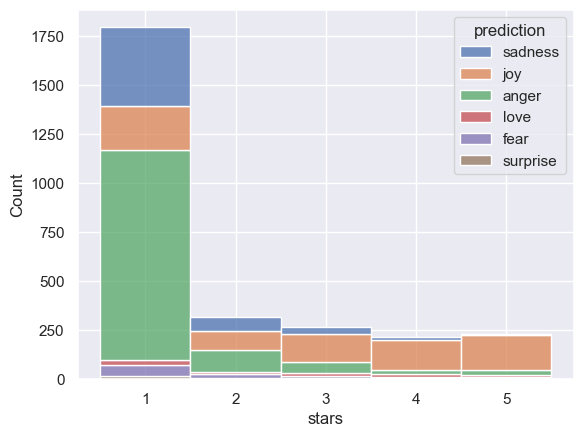

In [41]:
seaborn.histplot(
    data=ratings_sentiment, 
    x='stars', 
    hue='prediction', 
    multiple='stack', 
    discrete=True
)

<Axes: xlabel='prediction', ylabel='stars'>

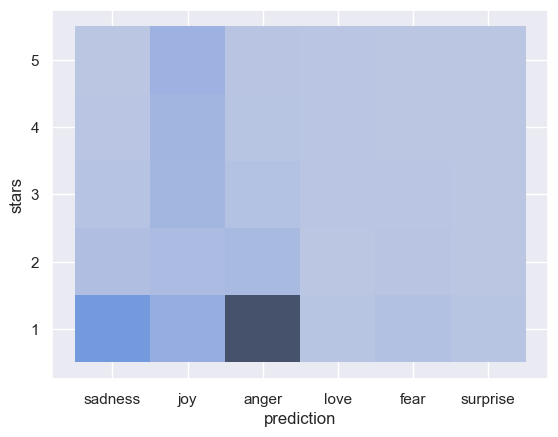

In [42]:
seaborn.histplot(
    data=ratings_sentiment, 
    x='prediction', 
    y='stars', 
    multiple='stack', 
    discrete=True
)

**Question:** What does your chart indicate for the effectiveness of our sentiment analysis? Does our original hypothesis about fast food restaurants seem plausible?

The charts support the hypothesis that fast food restaurants have worse reviews than typical restaurants. The majority of reviews for fast food restaurants fall into the 1-star rating and most of the emotion associated with said reviews is anger. The second plot was made to visualize the sentiment analysis in a slighty different way. This second chart also highlights the association of emotions such as anger and sadness with 1-star reviews of fast food restaurants. 